### Jupyter Notebook "2-TF_IDF_Cosine_&_Word2vec_WMD":  
* 3-Imports.
     * 3.1-Import librerias necesarias.
     * 3.2-Import de DFs del Jupyter Notebook anterior.
* 4-División DFs para usarlos en los distintos cálculos y entrenamientos.
* 5-Realizando Comparaciones y obteniendo Similitudes.
     * 5.1- TF-IDF & Cosine Similarity.
     * 5.2- Word Embedding (Word2vec) & WMD.
* 6-Observación valores de Cosine Similarity y WMD.
     * 6.1-Candidate 'Bradly Johnston (ML Engineer)'
     * 6.2-Job 'Security Specialist 2'.
* 7-Export del DF para usarlo en el siguiente Jupyter Notebook.

### 3-Imports.

### 3.1-Import librerias necesarias.

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

#Calculo de TFIDF y Cosine:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import paired_cosine_distances as pcd

#Word2vec: 
import gensim
from gensim.models import Word2Vec

#Para medir tiempos de ejecución:
from datetime import datetime

/home/fedricio/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 3.2-Import de DFs del Jupyter Notebook anterior.

In [2]:
df_Candidatos_loaded = pd.read_pickle('DF_624_CVs')
df_Candidatos_loaded.shape

(624, 3)

In [3]:
df_Candidatos_loaded.head()

,Candidate_Name,clean_Content_CV,tokens_Content_CV
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,..."
1,DataScientist_Rahul_Malik,nlp data_scientist brooklyn ny nlp data_scient...,"[nlp, data_scientist, brooklyn, ny, nlp, data_..."
2,HCM_Federico_Calonge,hcm technical consultant working oracle tool p...,"[hcm, technical, consultant, working, oracle, ..."
3,HCM_Robert_Smith,sap_hcm consultant com qwikresume marshville r...,"[sap_hcm, consultant, com, qwikresume, marshvi..."
4,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin..."


In [4]:
df_Jobs_loaded = pd.read_pickle('DF_20593_Job_Desc') # load
df_Jobs_loaded.shape

(20593, 3)

In [5]:
df_Jobs_loaded.head()

,Job_Title,clean_Job_Description,tokens_Job_Description
0,Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited..."
1,Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,..."
2,HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp..."
3,HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor..."
4,Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te..."


### 4-División DFs para usarlos en los distintos cálculos y entrenamientos.

Los DFs enteros (**df_Candidatos_loaded** - 624 CVs) y (**df_Jobs_loaded** - 20593 Puestos de IT) serán utilizados para entrenar TF-IDF y los Word Embeddings con nuestro Corpus para el cálculo de Cosine SImilarity y WMD respectivamete. 

Luego definiremos 2 nuevos DFs para obtener los cálculos de WMD y Cosine Sim.; y para luego entrenar K-means y KNN:   
  * **df_Candidatos_modif** - 31 CVs.  
  * **df_Jobs_modif** - 101 Jobs Descriptions.   

Al realizar los cálculos compararemos cada CV con cada Job Description, obteniendo un dataframe total **df_compar_cand_jobs** de 3131 filas con sus respectivo valores de WMD y Cosine Sim.

Por último eliminaremos 1 CV y 1 Job Description (un total de 131 filas) de **df_compar_cand_jobs**, estos los utilizaremos para clasificar nuevas muestras predeciendo con KNN.

De esta manera nos quedará el **df_compar_cand_jobs** con 3000 filas / puntos para entrenar K-means y KNN.

#### 4.1-Creación de df_Candidatos_modif

In [6]:
df_Candidatos_modif = df_Candidatos_loaded.truncate(before=0, after=100)
df_Candidatos_modif

,Candidate_Name,clean_Content_CV,tokens_Content_CV
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,..."
1,DataScientist_Rahul_Malik,nlp data_scientist brooklyn ny nlp data_scient...,"[nlp, data_scientist, brooklyn, ny, nlp, data_..."
2,HCM_Federico_Calonge,hcm technical consultant working oracle tool p...,"[hcm, technical, consultant, working, oracle, ..."
3,HCM_Robert_Smith,sap_hcm consultant com qwikresume marshville r...,"[sap_hcm, consultant, com, qwikresume, marshvi..."
4,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin..."
...,...,...,...
96,Naveen Arora,naveen arora current location_chicago il visa ...,"[naveen, arora, current, location_chicago, il,..."
97,Naveen Kumar Bandela,naveen kumar bandela java full_stack developer...,"[naveen, kumar, bandela, java, full_stack, dev..."
98,Naveen.S_Resume,naveen looking contribute design analysis deve...,"[naveen, looking, contribute, design, analysis..."
99,Navneeth Resume,navneet gupta project program_manager pmp pmp_...,"[navneet, gupta, project, program_manager, pmp..."


#### 4.2-Creación de df_Jobs_modif

In [7]:
df_Jobs_modif = df_Jobs_loaded.truncate(before=0, after=30)
df_Jobs_modif

,Job_Title,clean_Job_Description,tokens_Job_Description
0,Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited..."
1,Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,..."
2,HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp..."
3,HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor..."
4,Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te..."
5,Machine Learning Engineer 2,collaborate multidisciplinary_team gain_insigh...,"[collaborate, multidisciplinary_team, gain_ins..."
6,Security Specialist,fast_paced environment combine technical secur...,"[fast_paced, environment, combine, technical, ..."
7,Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin..."
8,Web Developer Full Stack,graduate_degree information technology similar...,"[graduate_degree, information, technology, sim..."
9,Web Developer Full Stack 2,enter existing codebases extend functionality ...,"[enter, existing, codebases, extend, functiona..."


###  5-Realizando Comparaciones y obteniendo Similitudes.

###### Creamos un nuevo DF concatenando los 2 dataframe de manera que se comparen todos los CVs con todos los Jobs:

In [8]:
df_compar_cand_jobs = pd.merge(df_Candidatos_modif.assign(A=1), df_Jobs_modif.assign(A=1), on='A').drop('A', 1)
df_compar_cand_jobs

<ipython-input-8-8d861a22d867>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_compar_cand_jobs = pd.merge(df_Candidatos_modif.assign(A=1), df_Jobs_modif.assign(A=1), on='A').drop('A', 1)


,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited..."
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,..."
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp..."
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor..."
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te..."
...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m..."
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t..."
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis..."
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki..."


### 5.1- TF-IDF & Cosine Similarity.

#### Definimos los vectores que utilizaremos para entrenar y evaluar TF-IDF / Cosine Sim:

In [9]:
#Para entrenar tf-idf usamos todo nuestro Corpus:
array_unicode_CV_train   = df_Candidatos_loaded['clean_Content_CV'].astype('U').values
array_unicode_Jobs_train = df_Jobs_loaded['clean_Job_Description'].astype('U').values

print(len(array_unicode_CV_train))
print(array_unicode_CV_train[0])       #Primer valor de la lista.
print(len(array_unicode_Jobs_train))
print(array_unicode_Jobs_train[20592]) #Último valor de la lista.

#Juntamos los vectores:
array_CV_and_Jobs_train = np.concatenate((array_unicode_CV_train, array_unicode_Jobs_train)) #np = numpy.
print(len(array_CV_and_Jobs_train)) 

print('###################################################################################')

#Y para transform usamos únicamente los que queremos evaluar:
array_unicode_CV_transf   = df_compar_cand_jobs['clean_Content_CV'].astype('U').values
array_unicode_Jobs_transf = df_compar_cand_jobs['clean_Job_Description'].astype('U').values
print(len(array_unicode_CV_transf))
print(len(array_unicode_Jobs_transf))

624
data_scientist brooklyn ny data_scientist grubhub current new_york ny implemented various time_series forecasting technique predict surge customer order lower average customer wait time minute github deployed recommendation engine production conditionally recommend menu item based past order history increase average order size designed model portland pilot program increase incentive driver peak ordering hour resulting_increase driver availability peak ordering time statistic rutgers university data_scientist new brunswick_nj adobe new_york ny worked product marketing team identify customer interaction free trial maximize likelihood conversion resulting conversion_rate increase built customer attrition random forest model improved monthly python numpy_panda scikit_learn retention basis point customer likely attrit kera flask servicing relevant product feature sql mysql postgres worked_closely product team build production git recommendation engine python improved average length user

In [ ]:
#Exportamos el DF de 3131 filas + estos 3 vectores para usarlos como ejemplo en '2.1-Entrenamiento de TF-IDF & Cosine para 4 ejemplos':

#type(array_unicode_CV_transf)  #type(array_unicode_CV_transf)

df_compar_cand_jobs.to_pickle('DF_Exportado_Jobs_And_CVs_Para2_1')   #DF de CVs y Descripciones de Puestos para agregar columna 'tfidf_cosine' una vez aplicado TF-IDF y Cosine Sim.
np.save('array_CV_and_Jobs_train.npy', array_CV_and_Jobs_train)      #vector de CVs y Descripciones de Puestos para entrenar TF-IDF.
np.save('array_unicode_CV_transf.npy', array_unicode_CV_transf)      #vector de CVs para aplicar Cosine Sim.
np.save('array_unicode_Jobs_transf.npy', array_unicode_Jobs_transf)  #vector de Descripciones de Puestos para aplicar Cosine Sim.

#### Entrenamos TF-IDF y lo aplicamos junto a Cosine Sim

In [11]:
#https://www.py4u.net/discuss/188191
    
#Ahora calcularemos cosine similarity usando vectores tf-idf entre 'search queries' y 'matched documents'.
#Mi 'search query' es la columna de clean_content_CV y el 'matched documents' son los clean_Job_Description.
    #Al hacer el FIT entrenamos nuestro modelo con los cvs y job descriptions. Este modelo luego lo usaremos 
    #al hacer el TRANSFORM donde le pasamos la query para que se fije los TF-IDF que tiene ya entrenados del modelo. 

#VEr imports:
    #TfidfVectorizer
    #pcd  (cosine)

# Inicializamos una instancia de tf-idf Vectorizer:
tfidf_vectorizer = TfidfVectorizer()

start_time_fit = datetime.now()

# Generamos los vectores tf-idf para el Corpus:
tfidf_vectorizer.fit(array_CV_and_Jobs_train)             #array_CV_and_Jobs_train obtenido en la celda anterior.

end_time_fit = datetime.now()
print('Duration train tf-idf: {}'.format(end_time_fit - start_time_fit))

import pickle

#Guardamos el TF_IDF:
pickle.dump(tfidf_vectorizer, open("vectorizer_tfidf.pickle", "wb"))

Duration train tf-idf: 0:00:03.961116


In [12]:
#Vocabulario:
#Cargamos el TF_IDF:
tfidf_vectorizer = pickle.load(open("vectorizer_tfidf.pickle", "rb"))

feature_names = tfidf_vectorizer.get_feature_names()
len(feature_names)

124141

In [11]:
#Calculamos cosine similarity:
    #Parametros de pcd:
        #Xarray-like of shape (n_samples, n_features)
        #Yarray-like of shape (n_samples, n_features)
    #Retorna:
        #distancesndarray of shape (n_samples,)

start_time_cosine = datetime.now()

A = tfidf_vectorizer.transform(array_unicode_CV_transf)   #array_unicode_CV_transf obtenido en la celda anterior. 
B = tfidf_vectorizer.transform(array_unicode_Jobs_transf) #array_unicode_Jobs_transf obtenido en la celda anterior. 

cosine = 1 - pcd(A, B)   #array de tamaño n_samples
df_compar_cand_jobs['tfidf_cosine'] = cosine

end_time_cosine = datetime.now()
print('Duration cosine: {}'.format(end_time_cosine - start_time_cosine))

df_compar_cand_jobs

Duration cosine: 0:00:03.207617


,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.042817
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111344
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018021
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013100
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050443
...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.025742
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.105683
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063452
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.080821


In [12]:
#Vemos por ejemplo los valores para el Candidato 'MLEngineer_Bradly_Johnston':

is_Bradly_Johnston =  df_compar_cand_jobs['Candidate_Name']=='MLEngineer_Bradly_Johnston'
new_DF = df_compar_cand_jobs[is_Bradly_Johnston]
print(new_DF.shape)
new_DF.head(10)                                                               

(31, 7)


,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine
124,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.159509
125,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.313058
126,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.041684
127,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.039275
128,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.246166
129,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer 2,collaborate multidisciplinary_team gain_insigh...,"[collaborate, multidisciplinary_team, gain_ins...",0.325581
130,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Security Specialist,fast_paced environment combine technical secur...,"[fast_paced, environment, combine, technical, ...",0.038583
131,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.025728
132,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Web Developer Full Stack,graduate_degree information technology similar...,"[graduate_degree, information, technology, sim...",0.035656
133,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Web Developer Full Stack 2,enter existing codebases extend functionality ...,"[enter, existing, codebases, extend, functiona...",0.053284


### 5.2- Word Embedding (Word2vec) & WMD.

#### Usamos un Word2vec entrenado con nuestro Corpus.


#### Unimos las columnas 'tokens_Job_Description' de 'df_Jobs_loaded' y 'tokens_Content_CV' de 'df_Candidatos_loaded' generando una lista de listas, la cual será nuestro Corpus que introduciremos a Word Embedding como entrenamiento:

In [13]:
corpus_token_jobs = df_Jobs_loaded['tokens_Job_Description']

In [14]:
corpus_token_jobs

0        [master_degree, stem, field, including_limited...
1        [reporting, director, data, analytics, senior,...
2        [oracle, cloud, hcm, absence, consultant, resp...
3        [peoplesoft, oracle_eb, implementation, suppor...
4        [leveraging_latest, machine, deep_learning, te...
                               ...                        
20588    [company, description, searching, talented, cr...
20589    [location_san, francisco, caterm, full_time, p...
20590    [take_pride, knowing, thousand, life, positive...
20591    [company, description, offer, youas, world_lea...
20592    [c_c, programmingdevelopment, win, programming...
Name: tokens_Job_Description, Length: 20593, dtype: object

In [15]:
corpus_token_cvs = df_Candidatos_loaded['tokens_Content_CV']
#corpus_token_cvs.tolist()

In [16]:
corpus_token_cvs

0      [data_scientist, brooklyn, ny, data_scientist,...
1      [nlp, data_scientist, brooklyn, ny, nlp, data_...
2      [hcm, technical, consultant, working, oracle, ...
3      [sap_hcm, consultant, com, qwikresume, marshvi...
4      [kasey, vista, detroit, senior, software_engin...
                             ...                        
619    [technical, c_asp, net, mvc, html_cs, javascri...
620    [detail, detail, pune_maharashtra, university,...
621    [technology, asp_net, mvc, unit_testing, entit...
622    [technical, category, language, c_c, oop, dot_...
623    [technical, programming_c, net, web, technolog...
Name: tokens_Content_CV, Length: 624, dtype: object

In [17]:
corpus_tokenizado_final = corpus_token_cvs.append(corpus_token_jobs) #Unimos las listas.

In [18]:
corpus_tokenizado_final

0        [data_scientist, brooklyn, ny, data_scientist,...
1        [nlp, data_scientist, brooklyn, ny, nlp, data_...
2        [hcm, technical, consultant, working, oracle, ...
3        [sap_hcm, consultant, com, qwikresume, marshvi...
4        [kasey, vista, detroit, senior, software_engin...
                               ...                        
20588    [company, description, searching, talented, cr...
20589    [location_san, francisco, caterm, full_time, p...
20590    [take_pride, knowing, thousand, life, positive...
20591    [company, description, offer, youas, world_lea...
20592    [c_c, programmingdevelopment, win, programming...
Length: 21217, dtype: object

In [19]:
lista_corpus_tokenizado_final = corpus_tokenizado_final.tolist()
lista_corpus_tokenizado_final[0]

['data_scientist',
 'brooklyn',
 'ny',
 'data_scientist',
 'grubhub',
 'current',
 'new_york',
 'ny',
 'implemented',
 'various',
 'time_series',
 'forecasting',
 'technique',
 'predict',
 'surge',
 'customer',
 'order',
 'lower',
 'average',
 'customer',
 'wait',
 'time',
 'minute',
 'github',
 'deployed',
 'recommendation',
 'engine',
 'production',
 'conditionally',
 'recommend',
 'menu',
 'item',
 'based',
 'past',
 'order',
 'history',
 'increase',
 'average',
 'order',
 'size',
 'designed',
 'model',
 'portland',
 'pilot',
 'program',
 'increase',
 'incentive',
 'driver',
 'peak',
 'ordering',
 'hour',
 'resulting_increase',
 'driver',
 'availability',
 'peak',
 'ordering',
 'time',
 'statistic',
 'rutgers',
 'university',
 'data_scientist',
 'new',
 'brunswick_nj',
 'adobe',
 'new_york',
 'ny',
 'worked',
 'product',
 'marketing',
 'team',
 'identify',
 'customer',
 'interaction',
 'free',
 'trial',
 'maximize',
 'likelihood',
 'conversion',
 'resulting',
 'conversion_rate',
 'i

In [20]:
len(lista_corpus_tokenizado_final)

21217

#### Modelo word2vec:

In [21]:
#Ver imports:
    #gensim
    #Word2Vec
start_time = datetime.now()

#Mediante la siguiente línea de código entrenamos al modelo Word2Vec mediante nuestras 21217 listas de palabras 
#contenidas en “lista_corpus_tokenizado_final”:

model=gensim.models.Word2Vec(sentences=lista_corpus_tokenizado_final,
                             min_count=2,
                             alpha=0.025,
                             epochs=5, 
                             vector_size=100,
                             window=15,
                             sg=1, 
                             hs=0,
                             negative=10)

#En este caso no dividimos en train y test, ya que no vamos a predecir palabras en base a contextos, lo que 
#haremos es utilizar este word embedding para calcular WMD, entonces usamos TODAS las sentencias como entrenamiento. 
#Parametros función Word2Vec:
    #sentences:   #es el vector que contiene todas las palabras de nuestro corpus de texto de todos los documentos, 
                  #las cuales serán usadas para el entrenamiento de la red neuronal. 
    #min_count:   #Ignora todas las palabras cuando la frecuencia de cada palabra es menor a 'min_count'. El valor 
                  #por defecto es 5. Si queremos añadir todas las palabras en nuestro corpus colocaremos un valor de '1'.
    #window:      #Tamaño del "filtro" que se usa para analizar el contexto entre una palbras y las otras.
    #sg:          #Indica si utiliza el algoritmo de entrenamiento CBOW o skip gram. Por defecto es 0 (CBOW), nosotros 
                  #utilizaremos skip gram.
    #alpha:       #Learning rate, por defecto (0.025).
    #epochs       #Número de iteraciones sobre el corpus, por defecto (5).
    #vector_size: #Tamaño del embedding resultante, lo dejamos por defecto (100).
    #hs=0         #Desactivamos hierarchical Softmax para usar negative sampling. 
    #negative=10  #Especifica cuantas "noise words" van a ser usadas para el negative sampling (usualmente es entre 5-20).
                  #5 es el valor por defecto, pero decidimos colocar 10 para tener mayor cantidad de datos de entrenamiento, más ejemplos (ya que nuestro dataset no es muy grande).    
        
model.save("Word2vec_Model")  #Guardamos nuestro modelo.
wrds=list(model.wv.vectors)   #El modelo nos da un VOCABULARIO con palabras con las cuales podemos consultar. 
print(len(wrds))              #Me devuelve las palabras/tokens totales y ÚNICAS (sin repetidas) de nuestro Corpus (=Nuestro VOCABULARIO).

end_time = datetime.now()
print('Duration Word2vec training: {}'.format(end_time - start_time))

60713
Duration Word2vec training: 0:00:19.487795


In [6]:
#Para cargar el modelo nuevamente:
#model = gensim.models.Word2Vec.load("Word2vec_Model")

In [7]:
#Imprimimos las 10 primeras palabras de nuestro VOCABULARIO (saber que no estan en órden por la propia implementación de gensim):
for index, word in enumerate(model.wv.index_to_key):
    if index == 10:
        break
    print(f"word {index}/{len(model.wv.index_to_key)} is {word}")

word 0/60713 is business
word 1/60713 is project
word 2/60713 is system
word 3/60713 is development
word 4/60713 is team
word 5/60713 is application
word 6/60713 is management
word 7/60713 is technology
word 8/60713 is design
word 9/60713 is client


In [8]:
#Imprimimos el vector 'data_scientist' (de dimensión 1x100, ya que 100 es el tamaño del vector de embeddings 
#que le indicamos al entrenar el modelo)
normed_vector = model.wv.get_vector("data_scientist")
print(normed_vector)

#Otra forma para imprimir estos vectores:
#wrds[0]  #Acá imprimiriamos el vector para "business" (arriba está en la posición 0)

[-1.0100532  -1.0739435  -0.2837995  -0.21934018 -0.39414248  0.431768
  0.7870109   1.1987252   0.02807715  0.36723888 -0.06362996 -0.24838836
  0.13970229 -0.4104615  -0.15942498 -0.14069991  0.4311964   0.25339454
 -0.7163697  -1.1791078   0.02465013  0.48703074  0.27532187 -0.16741434
 -0.7982925   0.3103815  -0.2682589  -0.341128    0.09525464 -0.16409445
 -0.21894927 -0.7111297   0.8086186  -1.0402728  -0.1676163   0.10781587
 -0.3996233   0.3140456  -1.3524671  -0.2275282  -0.14426762 -0.26552695
 -1.5425543   0.18198712  1.0949311   0.03006735  0.04846608  0.01426211
 -1.0429325  -0.26697767  0.18544249 -0.47435647  0.64723057 -0.43273878
  0.07296617  0.07976893  0.04106973  1.2784706  -0.22689557  0.5165529
  0.48510435  0.65974104  0.4472009  -0.08489984 -1.0182112   0.9372411
 -0.00856188  1.4297451   0.6941317  -0.55708206 -0.30787155 -0.14141603
 -0.00835913 -0.8819436   1.1272204   0.71299404  0.885767    0.41563436
  0.46450695  0.5357916  -0.80906373  0.11209682 -0.747

In [22]:
df_compar_cand_jobs

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.042817
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111344
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018021
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013100
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050443
...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.025742
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.105683
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063452
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.080821


In [204]:
#De esta manera debería ser lo que usemos dentro de la función wmd():
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
print(type(sentence_obama))
sentence_obama

<class 'list'>


['obama', 'speaks', 'to', 'the', 'media', 'in', 'illinois']

In [205]:
#Vemos que nuestra columna está en el formato CORRECTO:
primer_job_desc = df_compar_cand_jobs.loc[0,'tokens_Job_Description']
print(type(primer_job_desc))
primer_job_desc

<class 'list'>


['master_degree',
 'stem',
 'field',
 'including_limited',
 'computer_science',
 'statistic_applied',
 'mathematics',
 'operation',
 'research',
 'engineering',
 'economics',
 'social',
 'science',
 'physic',
 'chemistry',
 'providing',
 'advanced',
 'analytics',
 'within',
 'business',
 'setting',
 'data',
 'science',
 'implementation',
 'within',
 'business',
 'setting',
 'working',
 'raw',
 'missing',
 'data',
 'understanding',
 'programming',
 'fundamental',
 'understanding',
 'statistic',
 'excellent_communication',
 'preferred',
 'data_visualization',
 'tool',
 'time',
 'series',
 'working',
 'knowledge',
 'relational_database',
 'standard',
 'sql_query',
 'method',
 'proficiency_least',
 'one',
 'general',
 'programming_language',
 'python',
 'java',
 'c_c',
 'working',
 'big_data',
 'within',
 'hadoop',
 'environment',
 'working',
 'r_sa',
 'statistical',
 'package',
 'advanced',
 'statistical',
 'econometric',
 'data_mining',
 'tool',
 'method',
 'linear',
 'model',
 'linear_r

In [206]:
model.wv.get_vector('machine_learning')

array([-0.99525577, -0.6077188 ,  0.49346033, -0.55763036, -0.9796547 ,
       -0.68836665, -0.71350926, -1.4117522 ,  1.8915818 , -0.6506267 ,
        0.42556623, -0.26373655, -1.1735786 ,  0.51572156,  1.8493272 ,
       -0.7794592 ,  0.2914408 , -0.72422415, -2.4389746 , -0.6153202 ,
       -1.5892342 ,  1.0106893 , -1.0484846 ,  2.2489483 , -0.21412507,
        2.9172063 , -0.96349007, -1.3327242 ,  0.00416835,  1.3986703 ,
        1.4242766 , -0.22011311,  2.223857  , -1.1588553 , -1.4619132 ,
        0.1856661 , -1.7423491 ,  0.8147439 , -2.6550345 , -1.3177652 ,
        0.27040812,  0.5305417 ,  0.9915678 ,  0.22363521,  1.6627038 ,
       -2.082534  ,  0.45118788,  0.05226795, -0.7729668 , -0.7210281 ,
       -1.7114677 , -0.26790208, -0.13104407, -1.8135256 , -0.37597892,
       -0.50595236,  0.21065246,  0.22731315, -1.0537595 ,  0.47375342,
        0.6429516 ,  0.2106793 , -0.45202067,  0.09661713, -0.5713031 ,
        1.3932399 , -1.6853856 ,  3.1746583 , -1.5431623 ,  0.79

In [207]:
model.wv.wmdistance('deep_learning', 'machine_learning')  #Cálculo de wmd para 2 palabras.

0.3127839378571345

In [208]:
#No vamos a utilizar esta 'funcionalidad', pero para saber:

#Gracias a nuestros words embeddings obtenidos por el entrenamiento en el modelo word2vec,
#ahora podemos realizar funciones como 'most_similar'....testeamos nuestro modelo: 
ModeloPrueba=model.wv.most_similar("machine_learning")     

#La función most_similar busca palabras que esten semánticamente
#cercas (que sean parecidas) a una palabra dada (En este caso 'machine_learning').

In [209]:
print(ModeloPrueba)

[('deep_learning', 0.8419713377952576), ('artificial_intelligence', 0.8369033336639404), ('predictive_analytics', 0.834757387638092), ('computational', 0.8211137652397156), ('algorithm', 0.8190171718597412), ('data_mining', 0.8028570413589478), ('nlp', 0.7969160079956055), ('predictive', 0.7912158966064453), ('predictive_modeling', 0.7865807414054871), ('ml', 0.773136556148529)]


In [210]:
#Función WMD que usaremos:
def WMD(tokens_CV_Candidate,tokens_Job_Desc):
    return (model.wv.wmdistance(tokens_CV_Candidate, tokens_Job_Desc))  #'wmdistance' return the word mover distance between two documents. 

In [211]:
#Como prueba obtenemos el WMD comparando para la 1ra fila (entre las columnas tokens_Content_CV y tokens_Job_Description)
first_job_descr = df_compar_cand_jobs.loc[0,'tokens_Job_Description']
first_content_cv = df_compar_cand_jobs.loc[0,'tokens_Content_CV']

wmd_result = round(WMD(first_content_cv,first_job_descr),3)
print(wmd_result)
 
similarity_wdm = round((1/(1+wmd_result)),3)  
print(similarity_wdm)

0.934
0.517


In [212]:
#Aplicamos WMD para TODO el DF... entre el contenido del CV y la descripcion del puesto; 
#y el resultado lo guardamos en las columna 'WMD'.

#df_compar_cand_jobs['WMD'] = df_compar_cand_jobs.apply(lambda row: round(WMD(row['tokens_Content_CV'],row['tokens_Job_Description']),3), axis=1)
#APlicando lo de  --> similarity = 1 / (1 + distance):
#(#similarity = 1 / (1 + distance) https://groups.google.com/g/gensim/c/-pRZnsOEaPQ)

start_time = datetime.now()

df_compar_cand_jobs['WMD'] = df_compar_cand_jobs.apply(lambda row: round((1/(1+(WMD(row['tokens_Content_CV'],row['tokens_Job_Description'])))),3), axis=1)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 7:00:27.420719


In [ ]:
#Exportamos nuestro DF para guardar los resultados:
df_compar_cand_jobs.to_pickle('DF_Exportado_Jobs_And_Candidates_tfidf_cosine_and_wmd')

In [109]:
#Importamos nuestro DF:
df_compar_cand_jobs_loaded = pd.read_pickle('DF_Exportado_Jobs_And_Candidates_tfidf_cosine_and_wmd')
df_compar_cand_jobs_loaded.shape
df_compar_cand_jobs_loaded

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.042817,0.517
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111344,0.525
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018021,0.501
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013100,0.500
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050443,0.518
...,...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.025742,0.485
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.105683,0.516
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063452,0.512
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.080821,0.507


### 6-Observación valores de Cosine Similarity y WMD.

##### Vamos a ver ejemplos de los valores de Cosine Similarity y WMD para el Candidate 'MLEngineer_Bradly_Johnston' y el Job 'Security Specialist 2'.

##### Antes que nada redondeamos a 3 decimales la columna 'tfidf_cosine' para que no me la exprese en notación científica y para que tenga igual cantidad de decimales que WMD:

In [118]:
df_compar_cand_jobs_loaded['tfidf_cosine'] = df_compar_cand_jobs_loaded['tfidf_cosine'].round(3)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_compar_cand_jobs_loaded

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.043,0.517
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111,0.525
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018,0.501
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013,0.500
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050,0.518
...,...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.026,0.485
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.106,0.516
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063,0.512
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.081,0.507


### 6.1-Candidate 'Bradly Johnston (ML Engineer)'

In [112]:
df_MLEngineer_Bradly_Johnston = df_compar_cand_jobs_loaded.loc[df_compar_cand_jobs_loaded['Candidate_Name'] == 'MLEngineer_Bradly_Johnston']
df_MLEngineer_Bradly_Johnston
print(df_MLEngineer_Bradly_Johnston.shape)
df_MLEngineer_Bradly_Johnston

(31, 8)


,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
124,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.160,0.566
125,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.313,0.569
126,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.042,0.510
127,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.039,0.513
128,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.246,0.572
129,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer 2,collaborate multidisciplinary_team gain_insigh...,"[collaborate, multidisciplinary_team, gain_ins...",0.326,0.579
130,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Security Specialist,fast_paced environment combine technical secur...,"[fast_paced, environment, combine, technical, ...",0.039,0.533
131,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.026,0.510
132,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Web Developer Full Stack,graduate_degree information technology similar...,"[graduate_degree, information, technology, sim...",0.036,0.512
133,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Web Developer Full Stack 2,enter existing codebases extend functionality ...,"[enter, existing, codebases, extend, functiona...",0.053,0.536


In [113]:
#Ordenamos de mayor a menor de acuerdo a tfidf_cosine:
df_MLEngineer_Bradly_Johnston.sort_values(by=['tfidf_cosine'], ascending=False)

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
129,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer 2,collaborate multidisciplinary_team gain_insigh...,"[collaborate, multidisciplinary_team, gain_ins...",0.326,0.579
125,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.313,0.569
128,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.246,0.572
124,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.160,0.566
134,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",AUTOMATION TEST ENGINEER,looking selenium engineer must solid java codi...,"[looking, selenium, engineer, must, solid, jav...",0.092,0.556
136,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Business Solutions Architect,galaxe_solutionsevery day solution affect_peop...,"[galaxe_solutionsevery, day, solution, affect_...",0.086,0.543
142,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Front End Developer,fulltime_position javascript developer financi...,"[fulltime_position, javascript, developer, fin...",0.078,0.538
141,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Sr. Web Application Developer (Cloud Team) - C...,bluebeam looking_talented sr web developer pas...,"[bluebeam, looking_talented, sr, web, develope...",0.074,0.531
154,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",IT Business Analyst,genesis looking business analyst long_term con...,"[genesis, looking, business, analyst, long_ter...",0.067,0.526
151,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.065,0.535


In [114]:
#Ordenamos de mayor a menor de acuerdo a WMD:
df_MLEngineer_Bradly_Johnston.sort_values(by=['WMD'], ascending=False)

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
129,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer 2,collaborate multidisciplinary_team gain_insigh...,"[collaborate, multidisciplinary_team, gain_ins...",0.326,0.579
128,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.246,0.572
125,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.313,0.569
124,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.160,0.566
134,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",AUTOMATION TEST ENGINEER,looking selenium engineer must solid java codi...,"[looking, selenium, engineer, must, solid, jav...",0.092,0.556
136,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Business Solutions Architect,galaxe_solutionsevery day solution affect_peop...,"[galaxe_solutionsevery, day, solution, affect_...",0.086,0.543
142,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Front End Developer,fulltime_position javascript developer financi...,"[fulltime_position, javascript, developer, fin...",0.078,0.538
143,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Application Support Engineer,summaryour_client leading_provider online vide...,"[summaryour_client, leading_provider, online, ...",0.064,0.537
133,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Web Developer Full Stack 2,enter existing codebases extend functionality ...,"[enter, existing, codebases, extend, functiona...",0.053,0.536
151,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.065,0.535


#### Bar charts resumiendo lo descrito arriba:

<ipython-input-59-c433e5cf4e44>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MLEngineer_Bradly_Johnston.sort_values(by=['tfidf_cosine'], inplace= True)


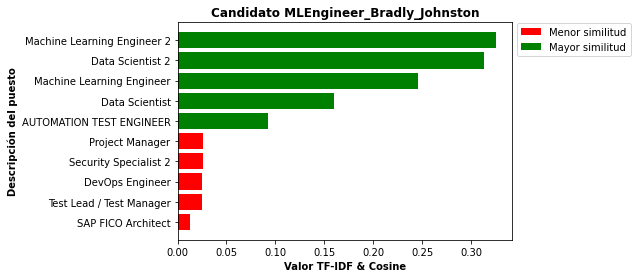

In [59]:
import matplotlib.pyplot as plt

# Create new df

df_MLEngineer_Bradly_Johnston.sort_values(by=['tfidf_cosine'], inplace= True)
df_MLEngineer_Bradly_Johnston.reset_index(drop=True, inplace= True)
#Top 5 y Bottom 5:
new_df = pd.concat([df_MLEngineer_Bradly_Johnston[:5], df_MLEngineer_Bradly_Johnston[-5:]])
new_df.insert(0,'Mayor-Menor Sim',['Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud'])

df_menor = new_df[:5]
df_mayor = new_df[-5:]

# Creating the bar plot
plt.barh(df_menor['Job_Title'], df_menor['tfidf_cosine'],color='r',label= 'Menor similitud')    
plt.barh(df_mayor['Job_Title'], df_mayor['tfidf_cosine'],color='g',label= 'Mayor similitud')

plt.xticks(rotation=0)
plt.xlabel("Valor TF-IDF & Cosine", fontweight='bold')
plt.ylabel("Descripción del puesto", fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

plt.title('Candidato MLEngineer_Bradly_Johnston',fontweight='bold')

plt.show()

<ipython-input-61-e451c6764c3d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MLEngineer_Bradly_Johnston.sort_values(by=['WMD'], inplace= True)


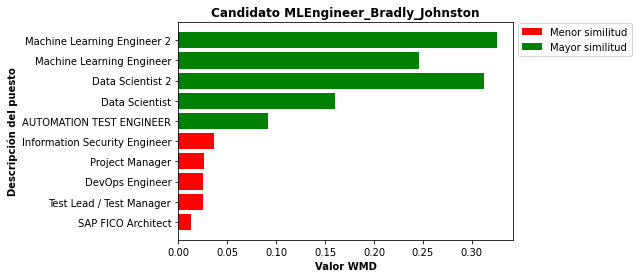

In [61]:
import matplotlib.pyplot as plt

# Create new df

df_MLEngineer_Bradly_Johnston.sort_values(by=['WMD'], inplace= True)
df_MLEngineer_Bradly_Johnston.reset_index(drop=True, inplace= True)
#Top 5 y Bottom 5:
new_df = pd.concat([df_MLEngineer_Bradly_Johnston[:5], df_MLEngineer_Bradly_Johnston[-5:]])
new_df.insert(0,'Mayor-Menor Sim',['Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud'])

df_menor = new_df[:5]
df_mayor = new_df[-5:]

# Creating the bar plot
plt.barh(df_menor['Job_Title'], df_menor['tfidf_cosine'],color='r',label= 'Menor similitud')    
plt.barh(df_mayor['Job_Title'], df_mayor['tfidf_cosine'],color='g',label= 'Mayor similitud')

plt.xticks(rotation=0)
plt.xlabel("Valor WMD", fontweight='bold')
plt.ylabel("Descripción del puesto", fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

plt.title('Candidato MLEngineer_Bradly_Johnston',fontweight='bold')

plt.show()

Observamos altos valores de similitud para ambas métricas para los puestos 'Machine Learning Engineer 2', 'Machine Learning Engineer', 'Data Scientist', 'Data Scientist 2' (algo esperable).  
Y tambien observamos bajos valores para puestos como 'SAP FICO Architect', 'Test Lead / Test Manager', 'DevOps Engineer', 'Project Manager' (algo esperble).

### 6.2-Job 'Security Specialist 2'.

In [115]:
df_Security_Specialist_2 = df_compar_cand_jobs_loaded.loc[df_compar_cand_jobs_loaded['Job_Title'] == 'Security Specialist 2']
df_Security_Specialist_2
print(df_Security_Specialist_2.shape)
df_Security_Specialist_2

(101, 8)


,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
7,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.010,0.492
38,DataScientist_Rahul_Malik,nlp data_scientist brooklyn ny nlp data_scient...,"[nlp, data_scientist, brooklyn, ny, nlp, data_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.012,0.491
69,HCM_Federico_Calonge,hcm technical consultant working oracle tool p...,"[hcm, technical, consultant, working, oracle, ...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.023,0.503
100,HCM_Robert_Smith,sap_hcm consultant com qwikresume marshville r...,"[sap_hcm, consultant, com, qwikresume, marshvi...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.011,0.498
131,MLEngineer_Bradly_Johnston,kasey vista detroit senior software_engineer m...,"[kasey, vista, detroit, senior, software_engin...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.026,0.510
...,...,...,...,...,...,...,...,...
2983,Naveen Arora,naveen arora current location_chicago il visa ...,"[naveen, arora, current, location_chicago, il,...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.055,0.513
3014,Naveen Kumar Bandela,naveen kumar bandela java full_stack developer...,"[naveen, kumar, bandela, java, full_stack, dev...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.029,0.498
3045,Naveen.S_Resume,naveen looking contribute design analysis deve...,"[naveen, looking, contribute, design, analysis...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.047,0.503
3076,Navneeth Resume,navneet gupta project program_manager pmp pmp_...,"[navneet, gupta, project, program_manager, pmp...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.092,0.521


In [117]:
#Ordenamos de mayor a menor de acuerdo a tfidf_cosine:
df_Security_Specialist_2.sort_values(by=['tfidf_cosine'], ascending=False)

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
224,SecuritySpecialist_Denis Banik,detail_oriented result_driven security analyst...,"[detail_oriented, result_driven, security, ana...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.131,0.526
193,SecuritySpecialist_Ahmed Wayne,abu_dhabi uae egyptian dynamic sr infrastructu...,"[abu_dhabi, uae, egyptian, dynamic, sr, infras...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.110,0.532
1433,Deepika Chintalapati,deepika around sr project_manager oracle_datab...,"[deepika, around, sr, project_manager, oracle_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.102,0.524
3076,Navneeth Resume,navneet gupta project program_manager pmp pmp_...,"[navneet, gupta, project, program_manager, pmp...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.092,0.521
1464,Deepika DC,deepika deepika experienced project_manager or...,"[deepika, deepika, experienced, project_manage...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.082,0.514
...,...,...,...,...,...,...,...,...
1123,Balakrishna Sudabathula,name balakrishna sudabathula software_developm...,"[name, balakrishna, sudabathula, software_deve...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.019,0.497
1154,Bapuji Hadoop developer,bapuji sr hadoop_developer including big_data ...,"[bapuji, sr, hadoop_developer, including, big_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.017,0.495
38,DataScientist_Rahul_Malik,nlp data_scientist brooklyn ny nlp data_scient...,"[nlp, data_scientist, brooklyn, ny, nlp, data_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.012,0.491
100,HCM_Robert_Smith,sap_hcm consultant com qwikresume marshville r...,"[sap_hcm, consultant, com, qwikresume, marshvi...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.011,0.498


In [116]:
#Ordenamos de mayor a menor de acuerdo a WMD:
df_Security_Specialist_2.sort_values(by=['WMD'], ascending=False)

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
193,SecuritySpecialist_Ahmed Wayne,abu_dhabi uae egyptian dynamic sr infrastructu...,"[abu_dhabi, uae, egyptian, dynamic, sr, infras...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.110,0.532
224,SecuritySpecialist_Denis Banik,detail_oriented result_driven security analyst...,"[detail_oriented, result_driven, security, ana...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.131,0.526
1433,Deepika Chintalapati,deepika around sr project_manager oracle_datab...,"[deepika, around, sr, project_manager, oracle_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.102,0.524
3076,Navneeth Resume,navneet gupta project program_manager pmp pmp_...,"[navneet, gupta, project, program_manager, pmp...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.092,0.521
2828,Murali_Project Manager QA,muralidhar chandrashekar st_louis mo currently...,"[muralidhar, chandrashekar, st_louis, mo, curr...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.067,0.520
...,...,...,...,...,...,...,...,...
1960,Jayadattaperi N,jayadattaperi looking contract c_c c role arou...,"[jayadattaperi, looking, contract, c_c, c, rol...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.031,0.493
7,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.010,0.492
2053,KIRAN KUMAR,kiran kumar mobile design ooa_ood development ...,"[kiran, kumar, mobile, design, ooa_ood, develo...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.029,0.491
38,DataScientist_Rahul_Malik,nlp data_scientist brooklyn ny nlp data_scient...,"[nlp, data_scientist, brooklyn, ny, nlp, data_...",Security Specialist 2,handling incoming_request assistance business ...,"[handling, incoming_request, assistance, busin...",0.012,0.491


#### Bar charts resumiendo lo descrito arriba:

<ipython-input-69-219b7a23274c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Security_Specialist_2.sort_values(by=['tfidf_cosine'], inplace= True)


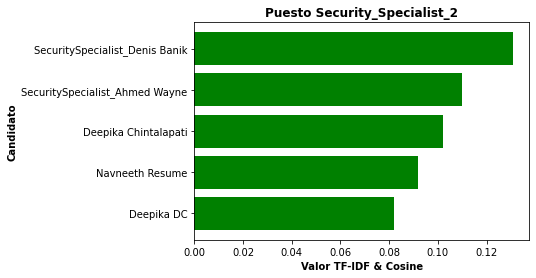

In [69]:
import matplotlib.pyplot as plt

# Create new df

df_Security_Specialist_2.sort_values(by=['tfidf_cosine'], inplace= True)
df_Security_Specialist_2.reset_index(drop=True, inplace= True)
#Top 5 y Bottom 5:
new_df = pd.concat([df_Security_Specialist_2[:5], df_Security_Specialist_2[-5:]])
new_df.insert(0,'Mayor-Menor Sim',['Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud'])

df_mayor = new_df[-5:]

# Creating the bar plot  
plt.barh(df_mayor['Candidate_Name'], df_mayor['tfidf_cosine'],color='g')

plt.xticks(rotation=0)
plt.xlabel("Valor TF-IDF & Cosine", fontweight='bold')
plt.ylabel("Candidato", fontweight='bold')

plt.title('Puesto Security_Specialist_2',fontweight='bold')

plt.show()

<ipython-input-70-7b219e500ab2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Security_Specialist_2.sort_values(by=['WMD'], inplace= True)


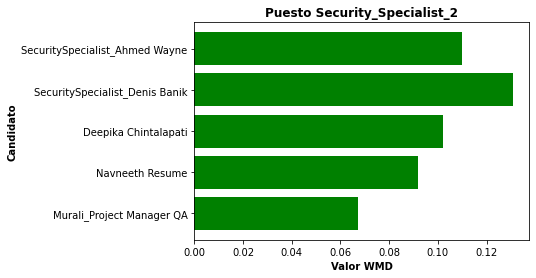

In [70]:
import matplotlib.pyplot as plt

# Create new df

df_Security_Specialist_2.sort_values(by=['WMD'], inplace= True)
df_Security_Specialist_2.reset_index(drop=True, inplace= True)
#Top 5 y Bottom 5:
new_df = pd.concat([df_Security_Specialist_2[:5], df_Security_Specialist_2[-5:]])
new_df.insert(0,'Mayor-Menor Sim',['Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Menor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud','Mayor Similitud'])

df_mayor = new_df[-5:]

# Creating the bar plot  
plt.barh(df_mayor['Candidate_Name'], df_mayor['tfidf_cosine'],color='g')

plt.xticks(rotation=0)
plt.xlabel("Valor WMD", fontweight='bold')
plt.ylabel("Candidato", fontweight='bold')

plt.title('Puesto Security_Specialist_2',fontweight='bold')

plt.show()

Observamos que los 2 Candidatos que tienen los mayores valores de similitud para ambas métricas son 'SecuritySpecialist_Denis Banik' y 'SecuritySpecialist_Ahmed Wayne' (algo esperable). 

### 7-Export del DF para usarlo en el siguiente Jupyter Notebook.

In [119]:
#Mostramos como se ve finalmente:
df_compar_cand_jobs_loaded

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.043,0.517
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111,0.525
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018,0.501
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013,0.500
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050,0.518
...,...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.026,0.485
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.106,0.516
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063,0.512
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.081,0.507
